<a href="https://colab.research.google.com/github/sakunisgithub/machine_learning/blob/master/0001_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary Installations and Imports

In [1]:
!pip install cupy-cuda12x --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: cupy-cuda12x
    Found existing installation: cupy-cuda12x 13.3.0
    Uninstalling cupy-cuda12x-13.3.0:
      Successfully uninstalled cupy-cuda12x-13.3.0


In [2]:
import cupy as cp

# Get GPU device properties
device = cp.cuda.Device(0)
props = device.attributes  # Get all attributes

print(f"CuPy version: {cp.__version__}")
print(f"GPU detected: {cp.cuda.is_available()}")
print(f"Device name: Tesla T4")  # We know this from nvidia-smi
print(f"Total memory: {device.mem_info[1]/1024**3:.2f} GB")

CuPy version: 13.4.1
GPU detected: True
Device name: Tesla T4
Total memory: 14.74 GB


In [3]:
from PIL import Image

from matplotlib import pyplot as plt

import requests
from io import BytesIO

import numpy as np
import cupy as cp

import pandas as pd

# Hovering over the data

In [4]:
def face_show(subject_number) :

    base_url = f"https://github.com/sakunisgithub/data_sets/raw/refs/heads/master/AT&T%20Database%20of%20Faces/s{subject_number}/"

    fig, axes = plt.subplots(1, 10, figsize = (15, 2))

    for i, ax in enumerate(axes.flat) :

        img_url = base_url + f"{i+1}.pgm" # this is the full Raw url

        response = requests.get(img_url) # sends an web request to the url, response.content has the raw bytes fetched from the url

        img = Image.open(BytesIO(response.content))
        # BytesIO creates a temporary file from the bytes, here in our case an image file, Image.open() read it as if it were a local file image

        ax.imshow(img, cmap = "gray")
        ax.axis('off')

    fig.suptitle(f"Subject {subject_number}")

    plt.show()

Enter Subject Number(1 to 40) = 1




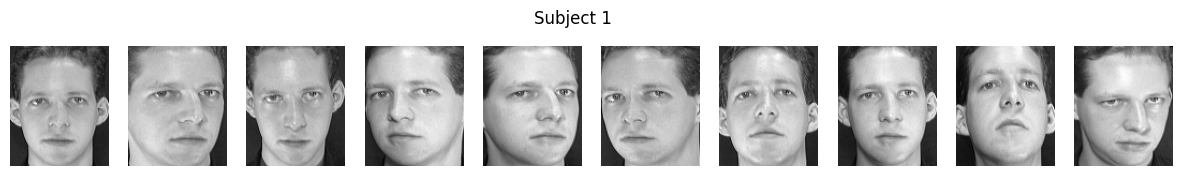

In [5]:
sub_num = int(input("Enter Subject Number(1 to 40) = "))

print("\n")

face_show(sub_num)

# Creating the Data-matrix

In [6]:
X = np.empty((400, 112*92))

In [7]:
for subject in range(40) :

    base_url = f"https://raw.githubusercontent.com/sakunisgithub/data_sets/master/AT&T%20Database%20of%20Faces/s{subject + 1}/"

    for image in range(10) :

        img_url = base_url + f"{image + 1}.pgm"

        response = requests.get(img_url)

        img = Image.open(BytesIO(response.content))

        img_pixel = np.array(img).flatten()

        X[subject * 10 + image] = img_pixel

In [8]:
print(X.shape)

(400, 10304)


# Recreating Images (just to be sure everything has gone perfect)

In [9]:
def recreate_image(num) :
    img = X[num - 1].reshape(112, 92) # original images were of size 112 X 92

    plt.imshow(img, cmap = "gray")
    plt.axis('off')
    plt.title(f"Image {num}")
    plt.show()

Enter image number (1 to 400) = 1




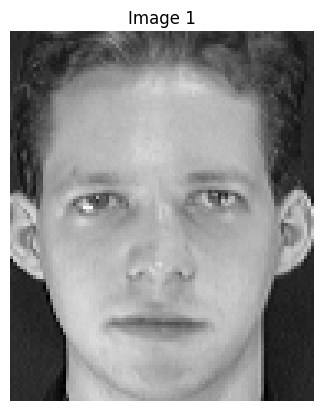

In [10]:
img_num = int(input("Enter image number (1 to 400) = "))

print("\n")

recreate_image(img_num)

# Standardizing the columns ($i.e.$ the features) of X

In [11]:
colmeans_X = np.mean(X, axis = 0)
colstds_X = np.std(X, axis = 0)

X_new = (X - colmeans_X) / colstds_X

In [12]:
print(X_new[0:5, 0:5])

[[-1.05125993 -1.02502268 -1.15078496 -1.08838219 -1.03953452]
 [-0.71590752 -0.71676625 -0.67275578 -0.92031391 -1.06762056]
 [-1.30277423 -1.16513923 -0.92583005 -1.368496   -0.70250205]
 [-0.63206942 -0.91292943 -1.4319786  -1.39650738 -1.48891115]
 [-0.60412339 -0.26839327 -0.16660723 -0.92031391 -1.46082511]]


In [13]:
# checking
np.where(np.round(np.mean(X_new, axis = 0), 0) != 0)

(array([], dtype=int64),)

# Calculating the Variance-Covariance Matrix

In [14]:
S = np.dot(X_new.T, X_new) / X_new.shape[0]

In [15]:
print(S.shape)

(10304, 10304)


In [16]:
print(S[0:5, 0:5])

[[1.         0.99357094 0.9924485  0.99220946 0.98955615]
 [0.99357094 1.         0.9934313  0.99411065 0.99084667]
 [0.9924485  0.9934313  1.         0.99330042 0.99194717]
 [0.99220946 0.99411065 0.99330042 1.         0.99278621]
 [0.98955615 0.99084667 0.99194717 0.99278621 1.        ]]


# Eigenvalues and Eigenvectors of S

In [17]:
cp_S = cp.array(S, dtype = cp.float64)

cp_eigvals, cp_eigvecs = cp.linalg.eigh(cp_S)

In [18]:
eigenvalues, eigenvectors = cp.asnumpy(cp_eigvals), cp.asnumpy(cp_eigvecs)

In [19]:
eigenvalues = eigenvalues[::-1] # sorting in descending order
eigenvectors = eigenvectors[:, ::-1] # adjusting the eigenvectors accordingly

In [20]:
print(eigenvalues[0:10])

[1658.61395752 1289.0473579   837.63556809  592.07810867  520.94184701
  315.80040416  245.48252803  224.87520865  213.65229232  200.16023089]


In [21]:
print(eigenvectors.shape)

(10304, 10304)


In [22]:
# top 300 eigenvalues
top_eigenvalues = eigenvalues[0:300]
print(top_eigenvalues.shape)

top_eigenvectors = eigenvectors[:, :300]
print(top_eigenvectors.shape)

(300,)
(10304, 300)


These 300 eigenvectors can be treated as $\textbf{eigenfaces}$.

# Eigenfaces

Let us see first 20 eigenfaces.

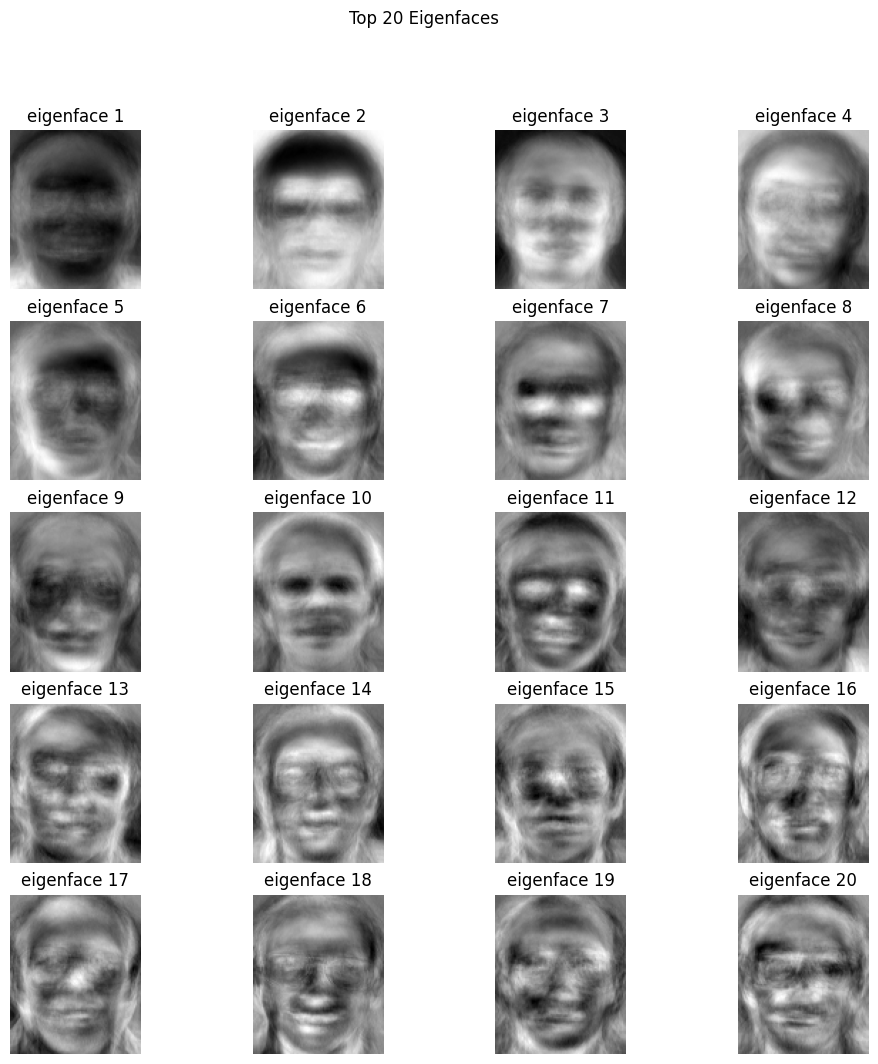

In [23]:
fig, axes = plt.subplots(5, 4, figsize = (12, 12))

for i, ax in enumerate(axes.flat) :
    ax.imshow(top_eigenvectors[:, i].reshape(112, 92).real, cmap = "gray")
    ax.axis('off')
    ax.set_title(f"eigenface {i+1}")

fig.suptitle("Top 20 Eigenfaces")

plt.show()

# Transformed Data

In [24]:
X_transformed = np.dot(X_new, top_eigenvectors)

# Reconstruction and Comparison

Now we shall try to reconstruct the images using these eigenfaces.

## Reconstruction

In [25]:
def reconstruct(img_num, k) :

    """
    img_num is the image number we want to reconstruct

    k denotes we want to use top k eigenvectors
    """

    reconstructed = np.dot(top_eigenvectors[:, :k].real, X_transformed[(img_num - 1), :k].real).flatten()

    reconstructed_and_unstandardized = reconstructed * colstds_X + colmeans_X

    plt.imshow(reconstructed_and_unstandardized.reshape(112, 92), cmap = "gray")

    plt.axis('off')

    plt.title(f"Image {img_num} : Reconstructed with k = {k}")

    plt.show()

Enter the image you want to reconstruct (1 to 400) = 1
How many top eigenvectors do you want to use ? (1 to 300) = 300




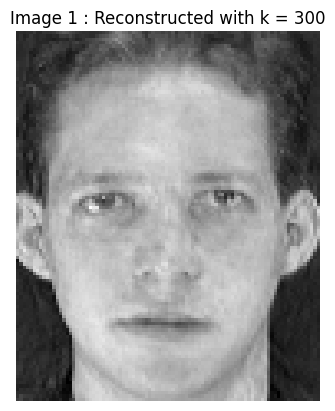

In [26]:
img_num = int(input("Enter the image you want to reconstruct (1 to 400) = "))
k = int(input("How many top eigenvectors do you want to use ? (1 to 300) = "))

print("\n")

reconstruct(img_num, k)

## Visualizing the Reconstruction

In [27]:
def visualize_reconstruction(img_num) :

    fig, axes = plt.subplots(6, 5, figsize = (20, 20))

    for i, ax in enumerate(axes.flat) :

        reconstructed = np.dot(top_eigenvectors[:, :(i*10)].real, X_transformed[(img_num - 1), :(i*10)].real).flatten()

        reconstructed_and_unstandardized = reconstructed * colstds_X + colmeans_X

        ax.imshow(reconstructed_and_unstandardized.reshape(112, 92), cmap = "gray")

        ax.axis('off')

        ax.set_title(f"k = {(i+1)*10}")

    fig.suptitle("Step-by-step Reconstruction")

    plt.show()

Enter the image you want to visualize reconstruction of (1 to 400) = 1


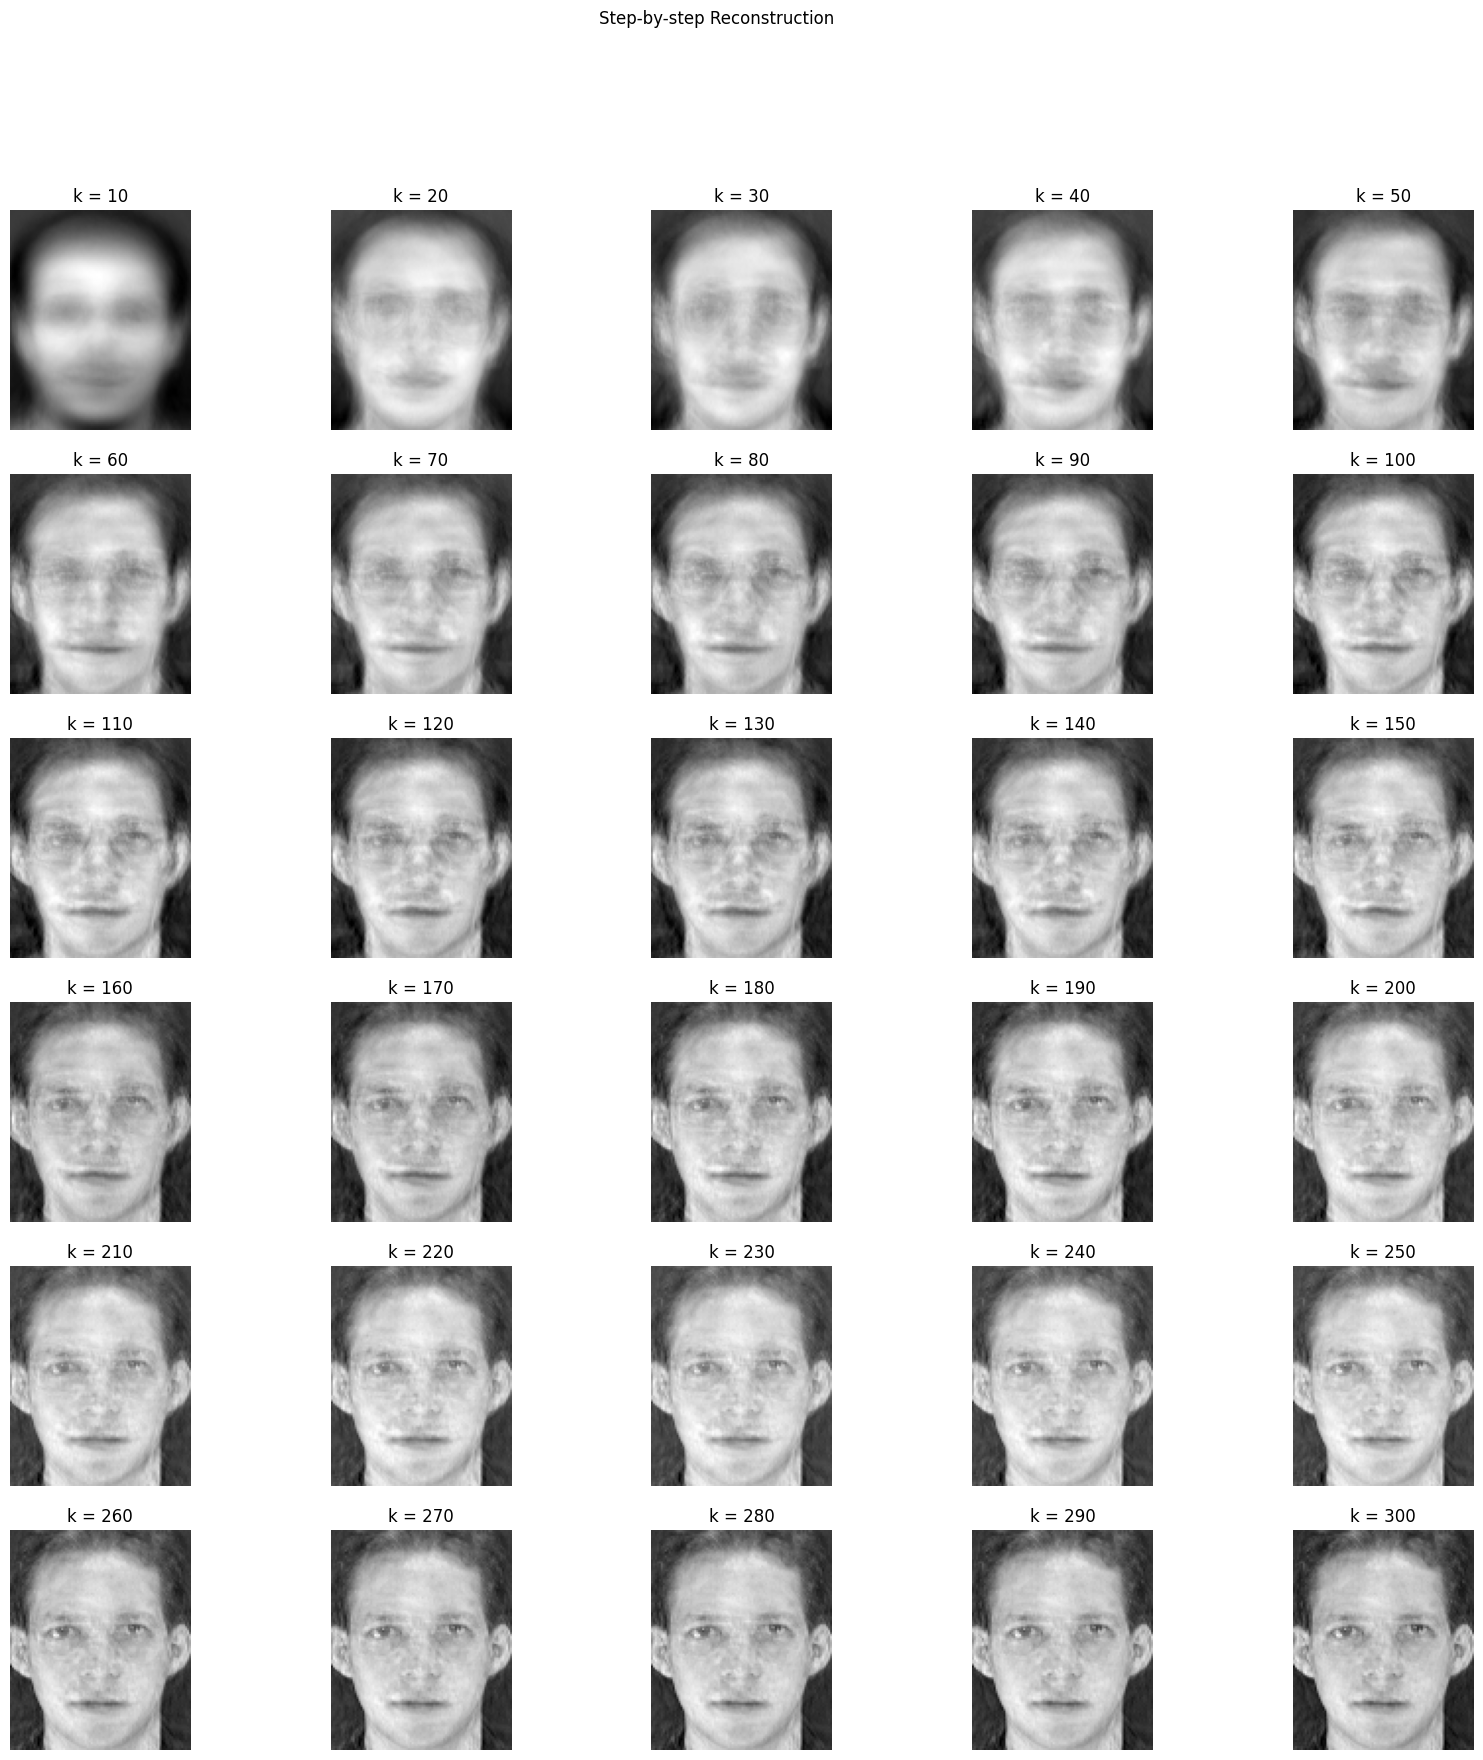

In [28]:
img_num = int(input("Enter the image you want to visualize reconstruction of (1 to 400) = "))

visualize_reconstruction(img_num)

## Comparison

In [29]:
def comparison(img_num) :

    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(X[img_num - 1].reshape(112, 92), cmap = "gray")
    axes[0].axis('off')
    axes[0].set_title("True Image")

    reconstructed = np.dot(top_eigenvectors[:, :300].real, X_transformed[(img_num - 1), :300].real).flatten()
    reconstructed_and_unstandardized = reconstructed * colstds_X + colmeans_X
    axes[1].imshow(reconstructed_and_unstandardized.reshape(112, 92), cmap = "gray")
    axes[1].axis('off')
    axes[1].set_title("Reconstructed Image")

    fig.suptitle(f"Comparison of Image {img_num}")

    plt.show()

Enter the image that you want to compare  (1 to 400) = 1


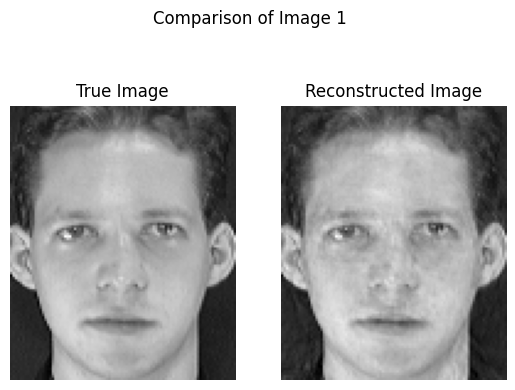

In [30]:
img_num = int(input("Enter the image that you want to compare  (1 to 400) = "))

comparison(img_num)

# What we achieved ?

In [31]:
print(f"Shape of our original data was {X.shape}.")

Shape of our original data was (400, 10304).


In [32]:
print(f"Shape of our transformed data is {X_transformed.shape}.")

Shape of our transformed data is (400, 300).


That's hell of a compression !! Woooooo !!